# 23-6. 프로젝트 - Movielens 영화 Session based Recommendation

In [1]:
import datetime as dt
from pathlib import Path
import os
import time
import numpy as np
import pandas as pd
import warnings
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

## Step 1. 데이터의 전처리

In [2]:
# 데이터 불러오기

data_path = Path(os.getenv('HOME')+'/aiffel/yoochoose-data/ml-1m') 
train_path = data_path / 'ratings.dat'

def load_data(data_path: Path, nrows=None):
    data = pd.read_csv(data_path, sep='::', header=None, usecols=[0, 1, 2, 3], dtype={0: np.int32, 1: np.int32, 2: np.int32}, nrows=nrows)
    data.columns = ['UserId', 'MovieId', 'Rating', 'Time']
    return data

train_data = load_data(train_path, None)
train_data.sort_values(['UserId', 'Time'], inplace=True)  # data를 id와 시간 순서로 정렬해줍니다.
train_data

,UserId,MovieId,Rating,Time
31,1,3186,4,978300019
22,1,1270,5,978300055
27,1,1721,4,978300055
37,1,1022,5,978300055
24,1,2340,3,978300103
...,...,...,...,...
1000019,6040,2917,4,997454429
999988,6040,1921,4,997454464
1000172,6040,1784,3,997454464
1000167,6040,161,3,997454486


In [3]:
user_path = data_path / 'users.dat'

def load_data_user(data_path: Path, nrows=None):
    data = pd.read_csv(data_path, sep='::', header=None, usecols=[0, 1, 2, 3, 4], dtype={0: np.int32, 2: np.int32, 3: np.int32}, nrows=nrows)
    data.columns = ['UserId', 'Gender', 'Age', 'Occupation', 'Zip-code']
    return data

user_data = load_data_user(user_path, None)
user_data.sort_values(['UserId'], inplace=True)  # data를 id 순서로 정렬해줍니다.
user_data

,UserId,Gender,Age,Occupation,Zip-code
0,1,F,1,10,48067
1,2,M,56,16,70072
2,3,M,25,15,55117
3,4,M,45,7,02460
4,5,M,25,20,55455
...,...,...,...,...,...
6035,6036,F,25,15,32603
6036,6037,F,45,1,76006
6037,6038,F,56,1,14706
6038,6039,F,45,0,01060


In [4]:
movie_path = data_path / 'movies.dat'

def load_data_movie(data_path: Path, nrows=None):
    data = pd.read_csv(data_path, sep='::', header=None, usecols=[0, 1, 2], dtype={0: np.int32}, nrows=nrows)
    data.columns = ['MovieId', 'Title', 'Genres']
    return data

movie_data = load_data_movie(movie_path, None)
movie_data.sort_values(['MovieId'], inplace=True)  # data를 id 순서로 정렬해줍니다.
movie_data

,MovieId,Title,Genres
0,1,Toy Story (1995),Animation|Children's|Comedy
1,2,Jumanji (1995),Adventure|Children's|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama
4,5,Father of the Bride Part II (1995),Comedy
...,...,...,...
3878,3948,Meet the Parents (2000),Comedy
3879,3949,Requiem for a Dream (2000),Drama
3880,3950,Tigerland (2000),Drama
3881,3951,Two Family House (2000),Drama


In [5]:
maping = {
'Action': 1,
'Adventure': 2,
'Animation': 3,
"Children's": 4,
'Comedy': 5,
'Crime': 6,
'Documentary': 7,
'Drama': 8,
'Fantasy': 9,
'Film-Noir': 10,
'Horror': 11,
'Musical': 12,
'Mystery': 13,
'Romance': 14,
'Sci-Fi': 15,
'Thriller': 16,
'War': 17,
'Western': 18}

In [6]:
movie_data['Genres'] = movie_data['Genres'].str.split('|')

In [7]:
movie_data

,MovieId,Title,Genres
0,1,Toy Story (1995),"[Animation, Children's, Comedy]"
1,2,Jumanji (1995),"[Adventure, Children's, Fantasy]"
2,3,Grumpier Old Men (1995),"[Comedy, Romance]"
3,4,Waiting to Exhale (1995),"[Comedy, Drama]"
4,5,Father of the Bride Part II (1995),[Comedy]
...,...,...,...
3878,3948,Meet the Parents (2000),[Comedy]
3879,3949,Requiem for a Dream (2000),[Drama]
3880,3950,Tigerland (2000),[Drama]
3881,3951,Two Family House (2000),[Drama]


In [8]:
data = pd.merge(train_data, movie_data, on='MovieId')
data = pd.merge(data, user_data, on='UserId')
data

,UserId,MovieId,Rating,Time,Title,Genres,Gender,Age,Occupation,Zip-code
0,1,3186,4,978300019,"Girl, Interrupted (1999)",[Drama],F,1,10,48067
1,1,1270,5,978300055,Back to the Future (1985),"[Comedy, Sci-Fi]",F,1,10,48067
2,1,1721,4,978300055,Titanic (1997),"[Drama, Romance]",F,1,10,48067
3,1,1022,5,978300055,Cinderella (1950),"[Animation, Children's, Musical]",F,1,10,48067
4,1,2340,3,978300103,Meet Joe Black (1998),[Romance],F,1,10,48067
...,...,...,...,...,...,...,...,...,...,...
1000204,4211,3791,2,965319075,Footloose (1984),[Drama],M,45,5,77662
1000205,4211,3840,4,965319197,Pumpkinhead (1988),[Horror],M,45,5,77662
1000206,4211,3806,3,965319138,MacKenna's Gold (1969),[Western],M,45,5,77662
1000207,4211,3766,2,965319138,Missing in Action (1984),"[Action, War]",M,45,5,77662


In [9]:
data = data[data['Rating']>=3]
data

,UserId,MovieId,Rating,Time,Title,Genres,Gender,Age,Occupation,Zip-code
0,1,3186,4,978300019,"Girl, Interrupted (1999)",[Drama],F,1,10,48067
1,1,1270,5,978300055,Back to the Future (1985),"[Comedy, Sci-Fi]",F,1,10,48067
2,1,1721,4,978300055,Titanic (1997),"[Drama, Romance]",F,1,10,48067
3,1,1022,5,978300055,Cinderella (1950),"[Animation, Children's, Musical]",F,1,10,48067
4,1,2340,3,978300103,Meet Joe Black (1998),[Romance],F,1,10,48067
...,...,...,...,...,...,...,...,...,...,...
1000200,4211,3764,4,965319041,F/X 2 (1992),"[Action, Crime, Thriller]",M,45,5,77662
1000201,4211,3841,4,965318857,Air America (1990),"[Action, Comedy]",M,45,5,77662
1000203,4211,3768,3,965318885,Braddock: Missing in Action III (1988),"[Action, War]",M,45,5,77662
1000205,4211,3840,4,965319197,Pumpkinhead (1988),[Horror],M,45,5,77662


In [10]:
data.drop(['Rating', 'Title', 'Genres', 'Gender', 'Age', 'Occupation', 'Zip-code'], axis='columns', inplace=True)
data

,UserId,MovieId,Time
0,1,3186,978300019
1,1,1270,978300055
2,1,1721,978300055
3,1,1022,978300055
4,1,2340,978300103
...,...,...,...
1000200,4211,3764,965319041
1000201,4211,3841,965318857
1000203,4211,3768,965318885
1000205,4211,3840,965319197


다른 요소들을 활용코자 하였으나 레이팅만 반영, 다른 요소는 배제한다.

In [11]:
# data['Time'] = data['Time'].map(lambda x : dt.datetime.fromtimestamp(x))
# data

In [12]:
# def time_changer(data_frame):
#     for i in range(1, len(data_frame)+1):
#         t = data_frame[data_frame['UserId'] == i]
#         base_time = t.iloc[0]['Time']
#         for j in range(1, len(t)+1):
#             data_frame[data_frame['UserId'] == i]['Time'][j] = t.iloc[j]['Time']-base_time
#         data_frame[data_frame['UserId'] == i]['Time'][0] = 0

시간을 index 혹은 datetime으로 변경하지 않아도 동일하게 작동한다.

In [13]:
data['UserId'].nunique(), data['MovieId'].nunique()

(6039, 3628)

In [14]:
session_length = data.groupby('UserId').size()
session_length

UserId
1        53
2       116
3        46
4        19
5       143
       ... 
6036    708
6037    189
6038     18
6039    119
6040    276
Length: 6039, dtype: int64

In [15]:
session_length.median(), session_length.mean()

(81.0, 138.51266766020865)

In [16]:
session_length.min(), session_length.max()

(1, 1968)

In [17]:
session_length.quantile(0.999)

1118.8860000000013

In [18]:
long_session = session_length[session_length==1968].index[0]
data[data['UserId']==long_session]

,UserId,MovieId,Time
103026,4169,3186,965693273
103027,4169,1270,968798421
103028,4169,1721,975804348
103029,4169,1022,971580156
103030,4169,2340,967164726
...,...,...,...
105335,4169,607,991268567
105336,4169,2214,1000082431
105337,4169,3229,1000082568
105338,4169,820,1014686602


Time을 고려할때 이상 없는 데이터임이 확인되었다,

In [19]:
length_count = session_length.groupby(session_length).size()
length_percent_cumsum = length_count.cumsum() / length_count.sum()
length_percent_cumsum_999 = length_percent_cumsum[length_percent_cumsum < 0.999]

In [20]:
length_percent_cumsum_999

1       0.000166
7       0.000331
9       0.000994
10      0.001159
11      0.001987
          ...   
1029    0.998013
1034    0.998344
1054    0.998510
1106    0.998675
1116    0.998841
Length: 636, dtype: float64

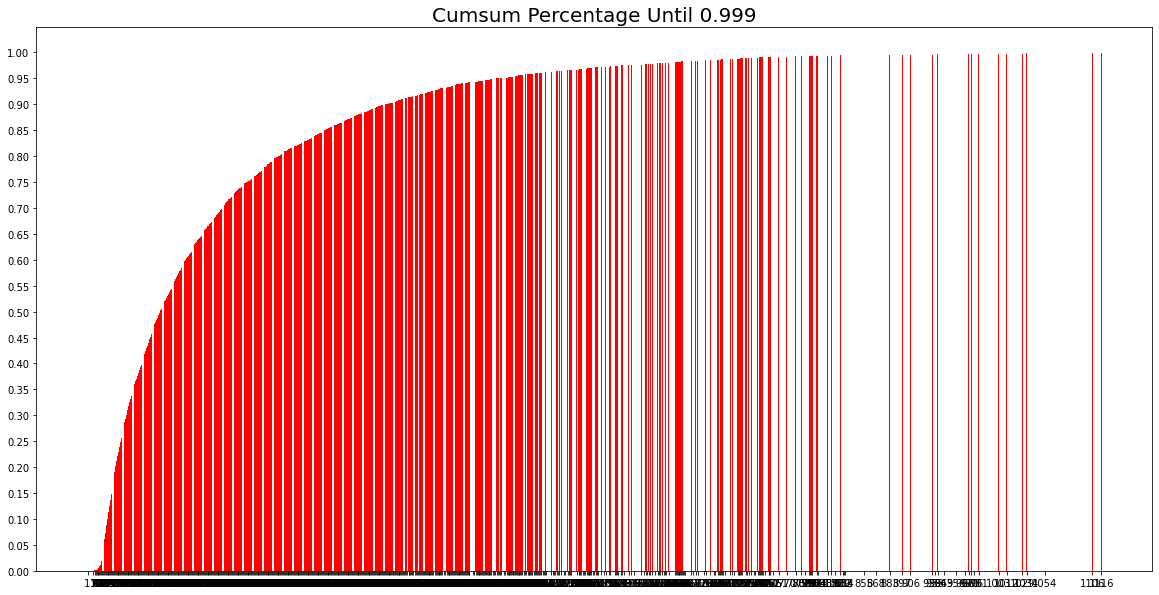

In [21]:
plt.figure(figsize=(20, 10))
plt.bar(x=length_percent_cumsum_999.index,
        height=length_percent_cumsum_999, color='red')
plt.xticks(length_percent_cumsum_999.index)
plt.yticks(np.arange(0, 1.01, 0.05))
plt.title('Cumsum Percentage Until 0.999', size=20)
plt.show()

In [22]:
oldest, latest = data['Time'].min(), data['Time'].max()
print(oldest) 
print(latest)

956703932
1046454590


In [23]:
type(latest)

numpy.int64

In [24]:
# month_ago = latest - dt.timedelta(30)     # 최종 날짜로부터 30일 이전 날짜를 구한다.  
# data = data[data['Time'] > month_ago]   # 방금 구한 날짜 이후의 데이터만 모은다. 
# data

In [25]:
# short_session을 제거한 다음 unpopular item을 제거하면 다시 길이가 1인 session이 생길 수 있습니다.
# 이를 위해 반복문을 통해 지속적으로 제거 합니다.
def cleanse_recursive(data: pd.DataFrame, shortest, least_click) -> pd.DataFrame:
    while True:
        before_len = len(data)
        data = cleanse_short_session(data, shortest)
        data = cleanse_unpopular_item(data, least_click)
        after_len = len(data)
        if before_len == after_len:
            break
    return data


def cleanse_short_session(data: pd.DataFrame, shortest):
    session_len = data.groupby('UserId').size()
    session_use = session_len[session_len >= shortest].index
    data = data[data['UserId'].isin(session_use)]
    return data


def cleanse_unpopular_item(data: pd.DataFrame, least_click):
    item_popular = data.groupby('MovieId').size()
    item_use = item_popular[item_popular >= least_click].index
    data = data[data['MovieId'].isin(item_use)]
    return data

In [26]:
data = cleanse_recursive(data, shortest=2, least_click=5)
data

,UserId,MovieId,Time
0,1,3186,978300019
1,1,1270,978300055
2,1,1721,978300055
3,1,1022,978300055
4,1,2340,978300103
...,...,...,...
1000200,4211,3764,965319041
1000201,4211,3841,965318857
1000203,4211,3768,965318885
1000205,4211,3840,965319197


In [27]:
# def split_by_date(data: pd.DataFrame, n_days: int):
#     final_time = data['Time'].max()
#     session_last_time = data.groupby('UserId')['Time'].max()
#     session_in_train = session_last_time[session_last_time < final_time - dt.timedelta(n_days)].index
#     session_in_test = session_last_time[session_last_time >= final_time - dt.timedelta(n_days)].index

#     before_date = data[data['UserId'].isin(session_in_train)]
#     after_date = data[data['UserId'].isin(session_in_test)]
#     after_date = after_date[after_date['MovieId'].isin(before_date['MovieId'])]
#     return before_date, after_date

In [28]:
tr, test = train_test_split(data, test_size = 0.1, shuffle = False)
tr, val = train_test_split(data, test_size = 0.2, shuffle = False)

In [29]:
# tr, test = split_by_date(data, n_days=1)
# tr, val = split_by_date(tr, n_days=1)

In [30]:
# data에 대한 정보를 살펴봅니다.
def stats_info(data: pd.DataFrame, status: str):
    print(f'* {status} Set Stats Info\n'
          f'\t Events: {len(data)}\n'
          f'\t Sessions: {data["UserId"].nunique()}\n'
          f'\t Items: {data["MovieId"].nunique()}\n'
          f'\t First Time : {data["Time"].min()}\n'
          f'\t Last Time : {data["Time"].max()}\n')

In [31]:
stats_info(tr, 'train')
stats_info(val, 'valid')
stats_info(test, 'test')

* train Set Stats Info
	 Events: 668631
	 Sessions: 3474
	 Items: 3307
	 First Time : 956703932
	 Last Time : 1046454590

* valid Set Stats Info
	 Events: 167158
	 Sessions: 2565
	 Items: 3211
	 First Time : 956706827
	 Last Time : 1044569661

* test Set Stats Info
	 Events: 83579
	 Sessions: 1557
	 Items: 3046
	 First Time : 956706827
	 Last Time : 1043677009



In [32]:
# train set에 없는 아이템이 val, test기간에 생길 수 있으므로 train data를 기준으로 인덱싱합니다.
id2idx = {item_id : index for index, item_id in enumerate(tr['MovieId'].unique())}

def indexing(df, id2idx):
    df['item_idx'] = df['MovieId'].map(lambda x: id2idx.get(x, -1))  # id2idx에 없는 아이템은 모르는 값(-1) 처리 해줍니다.
    return df

tr = indexing(tr, id2idx)
val = indexing(val, id2idx)
test = indexing(test, id2idx)

In [33]:
tr[tr['item_idx']<0]

,UserId,MovieId,Time,item_idx


In [34]:
len(tr)

668631

In [35]:
val[val['item_idx']<0]

,UserId,MovieId,Time,item_idx


In [36]:
len(val)

167158

In [37]:
test[test['item_idx']<0]

,UserId,MovieId,Time,item_idx


In [38]:
len(test)

83579

In [39]:
save_path = data_path / 'processed'
save_path.mkdir(parents=True, exist_ok=True)

tr.to_pickle(save_path / 'train.pkl')
val.to_pickle(save_path / 'valid.pkl')
test.to_pickle(save_path / 'test.pkl')

## Step 2. 미니 배치의 구성

실습코드 내역을 참고하여 데이터셋과 미니 배치를 구성해 봅시다. Session-Parallel Mini-Batch의 개념에 따라, 학습 속도의 저하가 최소화될 수 있도록 구성합니다.
단, 위 Step 1에서 Session 단위를 어떻게 정의했느냐에 따라서 Session-Parallel Mini-Batch이 굳이 필요하지 않을 수도 있습니다.

In [40]:
class SessionDataset:
    """Credit to yhs-968/pyGRU4REC."""

    def __init__(self, data):
        self.df = data
        self.click_offsets = self.get_click_offsets()
        self.session_idx = np.arange(self.df['UserId'].nunique())  # indexing to SessionId

    def get_click_offsets(self):
        """
        Return the indexes of the first click of each session IDs,
        """
        offsets = np.zeros(self.df['UserId'].nunique() + 1, dtype=np.int32)
        offsets[1:] = self.df.groupby('UserId').size().cumsum()
        return offsets

In [41]:
tr_dataset = SessionDataset(tr)
tr_dataset.df.head(60)

,UserId,MovieId,Time,item_idx
0,1,3186,978300019,0
1,1,1270,978300055,1
2,1,1721,978300055,2
3,1,1022,978300055,3
4,1,2340,978300103,4
5,1,1836,978300172,5
6,1,3408,978300275,6
7,1,2804,978300719,7
8,1,1207,978300719,8
9,1,1193,978300760,9


In [42]:
tr_dataset.click_offsets

array([     0,     53,     99, ..., 668236, 668355, 668631], dtype=int32)

In [43]:
tr_dataset.session_idx

array([   0,    1,    2, ..., 3471, 3472, 3473])

In [44]:
class SessionDataLoader:
    """Credit to yhs-968/pyGRU4REC."""

    def __init__(self, dataset: SessionDataset, batch_size=50):
        self.dataset = dataset
        self.batch_size = batch_size

    def __iter__(self):
        """ Returns the iterator for producing session-parallel training mini-batches.
        Yields:
            input (B,):  Item indices that will be encoded as one-hot vectors later.
            target (B,): a Variable that stores the target item indices
            masks: Numpy array indicating the positions of the sessions to be terminated
        """

        start, end, mask, last_session, finished = self.initialize()  # initialize 메소드에서 확인해주세요.
        """
        start : Index Where Session Start
        end : Index Where Session End
        mask : indicator for the sessions to be terminated
        """

        while not finished:
            min_len = (end - start).min() - 1  # Shortest Length Among Sessions
            for i in range(min_len):
                # Build inputs & targets
                inp = self.dataset.df['item_idx'].values[start + i]
                target = self.dataset.df['item_idx'].values[start + i + 1]
                yield inp, target, mask

            start, end, mask, last_session, finished = self.update_status(start, end, min_len, last_session, finished)

    def initialize(self):
        first_iters = np.arange(self.batch_size)    # 첫 배치에 사용할 세션 Index를 가져옵니다.
        last_session = self.batch_size - 1    # 마지막으로 다루고 있는 세션 Index를 저장해둡니다.
        start = self.dataset.click_offsets[self.dataset.session_idx[first_iters]]       # data 상에서 session이 시작된 위치를 가져옵니다.
        end = self.dataset.click_offsets[self.dataset.session_idx[first_iters] + 1]  # session이 끝난 위치 바로 다음 위치를 가져옵니다.
        mask = np.array([])   # session의 모든 아이템을 다 돌은 경우 mask에 추가해줄 것입니다.
        finished = False         # data를 전부 돌았는지 기록하기 위한 변수입니다.
        return start, end, mask, last_session, finished

    def update_status(self, start: np.ndarray, end: np.ndarray, min_len: int, last_session: int, finished: bool):  
        # 다음 배치 데이터를 생성하기 위해 상태를 update합니다.
        
        start += min_len   # __iter__에서 min_len 만큼 for문을 돌았으므로 start를 min_len 만큼 더해줍니다.
        mask = np.arange(self.batch_size)[(end - start) == 1]  
        # end는 다음 세션이 시작되는 위치인데 start와 한 칸 차이난다는 것은 session이 끝났다는 뜻입니다. mask에 기록해줍니다.

        for i, idx in enumerate(mask, start=1):  # mask에 추가된 세션 개수만큼 새로운 세션을 돌것입니다.
            new_session = last_session + i  
            if new_session > self.dataset.session_idx[-1]:  # 만약 새로운 세션이 마지막 세션 index보다 크다면 모든 학습데이터를 돈 것입니다.
                finished = True
                break
            # update the next starting/ending point
            start[idx] = self.dataset.click_offsets[self.dataset.session_idx[new_session]]     # 종료된 세션 대신 새로운 세션의 시작점을 기록합니다.
            end[idx] = self.dataset.click_offsets[self.dataset.session_idx[new_session] + 1]

        last_session += len(mask)  # 마지막 세션의 위치를 기록해둡니다.
        return start, end, mask, last_session, finished

In [45]:
tr_data_loader = SessionDataLoader(tr_dataset, batch_size=4)
tr_dataset.df.head(15)

,UserId,MovieId,Time,item_idx
0,1,3186,978300019,0
1,1,1270,978300055,1
2,1,1721,978300055,2
3,1,1022,978300055,3
4,1,2340,978300103,4
5,1,1836,978300172,5
6,1,3408,978300275,6
7,1,2804,978300719,7
8,1,1207,978300719,8
9,1,1193,978300760,9


In [46]:
iter_ex = iter(tr_data_loader)

In [47]:
inputs, labels, mask =  next(iter_ex)
print(f'Model Input Item Idx are : {inputs}')
print(f'Label Item Idx are : {"":5} {labels}')
print(f'Previous Masked Input Idx are {mask}')

Model Input Item Idx are : [ 0  0 89 63]
Label Item Idx are :       [ 1  2 90 64]
Previous Masked Input Idx are []


## Step 3. 모델 구성

이 부분도 실습코드 내역을 참고하여 다양하게 모델 구조를 시도해볼 수 있습니다.

In [48]:
def mrr_k(pred, truth: int, k: int):
    indexing = np.where(pred[:k] == truth)[0]
    if len(indexing) > 0:
        return 1 / (indexing[0] + 1)
    else:
        return 0


def recall_k(pred, truth: int, k: int) -> int:
    answer = truth in pred[:k]
    return int(answer)

In [49]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Dropout, GRU
from tensorflow.keras.losses import categorical_crossentropy
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from tqdm import tqdm

In [50]:
def create_model(args):
    inputs = Input(batch_shape=(args.batch_size, 1, args.num_items))
    gru, _ = GRU(args.hsz, stateful=True, return_state=True, name='GRU')(inputs)
    dropout = Dropout(args.drop_rate)(gru)
    predictions = Dense(args.num_items, activation='softmax')(dropout)
    model = Model(inputs=inputs, outputs=[predictions])
    model.compile(loss=categorical_crossentropy, optimizer=Adam(args.lr), metrics=['accuracy'])
    model.summary()
    return model

In [51]:
class Args:
    def __init__(self, tr, val, test, batch_size, hsz, drop_rate, lr, epochs, k):
        self.tr = tr
        self.val = val
        self.test = test
        self.num_items = tr['MovieId'].nunique()
        self.num_sessions = tr['UserId'].nunique()
        self.batch_size = batch_size
        self.hsz = hsz
        self.drop_rate = drop_rate
        self.lr = lr
        self.epochs = epochs
        self.k = k

args = Args(tr, val, test, batch_size=16, hsz=50, drop_rate=0.1, lr=0.001, epochs=3, k=20)

In [52]:
model = create_model(args)

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(16, 1, 3307)]           0         
_________________________________________________________________
GRU (GRU)                    [(16, 50), (16, 50)]      503850    
_________________________________________________________________
dropout (Dropout)            (16, 50)                  0         
_________________________________________________________________
dense (Dense)                (16, 3307)                168657    
Total params: 672,507
Trainable params: 672,507
Non-trainable params: 0
_________________________________________________________________


## Step 4. 모델 학습

In [53]:
# train 셋으로 학습하면서 valid 셋으로 검증합니다.
def train_model(model, args):
    train_dataset = SessionDataset(args.tr)
    train_loader = SessionDataLoader(train_dataset, batch_size=args.batch_size)

    for epoch in range(1, args.epochs + 1):
        total_step = len(args.tr) - args.tr['UserId'].nunique()
        tr_loader = tqdm(train_loader, total=total_step // args.batch_size, desc='Train', mininterval=1)
        for feat, target, mask in tr_loader:
            reset_hidden_states(model, mask)  # 종료된 session은 hidden_state를 초기화합니다. 아래 메서드에서 확인해주세요.

            input_ohe = to_categorical(feat, num_classes=args.num_items)
            input_ohe = np.expand_dims(input_ohe, axis=1)
            target_ohe = to_categorical(target, num_classes=args.num_items)

            result = model.train_on_batch(input_ohe, target_ohe)
            tr_loader.set_postfix(train_loss=result[0], accuracy = result[1])

        val_recall, val_mrr = get_metrics(args.val, model, args, args.k)  # valid set에 대해 검증합니다.

        print(f"\t - Recall@{args.k} epoch {epoch}: {val_recall:3f}")
        print(f"\t - MRR@{args.k}    epoch {epoch}: {val_mrr:3f}\n")


def reset_hidden_states(model, mask):
    gru_layer = model.get_layer(name='GRU')  # model에서 gru layer를 가져옵니다.
    hidden_states = gru_layer.states[0].numpy()  # gru_layer의 parameter를 가져옵니다.
    for elt in mask:  # mask된 인덱스 즉, 종료된 세션의 인덱스를 돌면서
        hidden_states[elt, :] = 0  # parameter를 초기화 합니다.
    gru_layer.reset_states(states=hidden_states)


def get_metrics(data, model, args, k: int):  # valid셋과 test셋을 평가하는 코드입니다. 
                                             # train과 거의 같지만 mrr, recall을 구하는 라인이 있습니다.
    dataset = SessionDataset(data)
    loader = SessionDataLoader(dataset, batch_size=args.batch_size)
    recall_list, mrr_list = [], []

    total_step = len(data) - data['UserId'].nunique()
    for inputs, label, mask in tqdm(loader, total=total_step // args.batch_size, desc='Evaluation', mininterval=1):
        reset_hidden_states(model, mask)
        input_ohe = to_categorical(inputs, num_classes=args.num_items)
        input_ohe = np.expand_dims(input_ohe, axis=1)

        pred = model.predict(input_ohe, batch_size=args.batch_size)
        pred_arg = tf.argsort(pred, direction='DESCENDING')  # softmax 값이 큰 순서대로 sorting 합니다.

        length = len(inputs)
        recall_list.extend([recall_k(pred_arg[i], label[i], k) for i in range(length)])
        mrr_list.extend([mrr_k(pred_arg[i], label[i], k) for i in range(length)])

    recall, mrr = np.mean(recall_list), np.mean(mrr_list)
    return recall, mrr

In [54]:
# 학습 시간이 다소 오래 소요됩니다. (예상시간 1시간)
train_model(model, args)

Train:   0%|          | 0/41572 [00:00<?, ?it/s, accuracy=0.125, train_loss=2.6] 

	 - Recall@20 epoch 1: 0.697282
	 - MRR@20    epoch 1: 0.311291



Train:   0%|          | 0/41572 [00:00<?, ?it/s, accuracy=0.312, train_loss=2.8] 

	 - Recall@20 epoch 2: 0.715832
	 - MRR@20    epoch 2: 0.320861



Evaluation:  99%|█████████▉| 10229/10287 [05:25<00:01, 31.38it/s]

	 - Recall@20 epoch 3: 0.722016
	 - MRR@20    epoch 3: 0.324972



다양한 하이퍼파라미터를 변경해 보며 검증해 보도록 합니다. 실습코드에 언급되었던 Recall, MRR 등의 개념들도 함께 관리될 수 있도록 합니다.

## Step 5. 모델 테스트

미리 구성한 테스트셋을 바탕으로 Recall, MRR 을 확인해 봅니다.

In [55]:
def test_model(model, args, test):
    test_recall, test_mrr = get_metrics(test, model, args, 20)
    print(f"\t - Recall@{args.k}: {test_recall:3f}")
    print(f"\t - MRR@{args.k}: {test_mrr:3f}\n")

test_model(model, args, test)

Evaluation:  99%|█████████▉| 5081/5126 [02:47<00:01, 30.40it/s]

	 - Recall@20: 0.681879
	 - MRR@20: 0.303124



In [56]:
args = Args(tr, val, test, batch_size=16, hsz=50, drop_rate=0.1, lr=0.001, epochs=20, k=20)
model = create_model(args)

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(16, 1, 3307)]           0         
_________________________________________________________________
GRU (GRU)                    [(16, 50), (16, 50)]      503850    
_________________________________________________________________
dropout_1 (Dropout)          (16, 50)                  0         
_________________________________________________________________
dense_1 (Dense)              (16, 3307)                168657    
Total params: 672,507
Trainable params: 672,507
Non-trainable params: 0
_________________________________________________________________


In [57]:
train_model(model, args)

Train:   0%|          | 0/41572 [00:00<?, ?it/s, accuracy=0.25, train_loss=2.82] 

	 - Recall@20 epoch 1: 0.696653
	 - MRR@20    epoch 1: 0.311981



Train:   0%|          | 0/41572 [00:00<?, ?it/s, accuracy=0.188, train_loss=2.84]

	 - Recall@20 epoch 2: 0.714531
	 - MRR@20    epoch 2: 0.321197



Train:   0%|          | 0/41572 [00:00<?, ?it/s, accuracy=0.25, train_loss=2.89] 

	 - Recall@20 epoch 3: 0.720482
	 - MRR@20    epoch 3: 0.324022



Train:   0%|          | 0/41572 [00:00<?, ?it/s, accuracy=0.188, train_loss=2.58]

	 - Recall@20 epoch 4: 0.723055
	 - MRR@20    epoch 4: 0.326110



Train:   0%|          | 0/41572 [00:00<?, ?it/s, accuracy=0.25, train_loss=2.87] 

	 - Recall@20 epoch 5: 0.723421
	 - MRR@20    epoch 5: 0.325793



Train:   0%|          | 0/41572 [00:00<?, ?it/s, accuracy=0.25, train_loss=2.91] 

	 - Recall@20 epoch 6: 0.723837
	 - MRR@20    epoch 6: 0.326062



Train:   0%|          | 0/41572 [00:00<?, ?it/s, accuracy=0.25, train_loss=2.75] 

	 - Recall@20 epoch 7: 0.724497
	 - MRR@20    epoch 7: 0.326519



Train:   0%|          | 0/41572 [00:00<?, ?it/s, accuracy=0.125, train_loss=2.8] 

	 - Recall@20 epoch 8: 0.724081
	 - MRR@20    epoch 8: 0.326260



Train:   0%|          | 0/41572 [00:00<?, ?it/s, accuracy=0.25, train_loss=2.87] 

	 - Recall@20 epoch 9: 0.724613
	 - MRR@20    epoch 9: 0.327100



Train:   0%|          | 0/41572 [00:00<?, ?it/s, accuracy=0.25, train_loss=2.83] 

	 - Recall@20 epoch 10: 0.724503
	 - MRR@20    epoch 10: 0.326945



Train:   0%|          | 0/41572 [00:00<?, ?it/s, accuracy=0.188, train_loss=2.87]

	 - Recall@20 epoch 11: 0.724466
	 - MRR@20    epoch 11: 0.326645



Train:   0%|          | 0/41572 [00:00<?, ?it/s, accuracy=0.188, train_loss=2.7] 

	 - Recall@20 epoch 12: 0.724686
	 - MRR@20    epoch 12: 0.326792



Train:   0%|          | 0/41572 [00:00<?, ?it/s, accuracy=0.125, train_loss=2.68]

	 - Recall@20 epoch 13: 0.725114
	 - MRR@20    epoch 13: 0.326814



Train:   0%|          | 0/41572 [00:00<?, ?it/s, accuracy=0.25, train_loss=2.86] 

	 - Recall@20 epoch 14: 0.725236
	 - MRR@20    epoch 14: 0.326724



Train:   0%|          | 0/41572 [00:00<?, ?it/s, accuracy=0.125, train_loss=2.61]

	 - Recall@20 epoch 15: 0.724723
	 - MRR@20    epoch 15: 0.326549



Train:   0%|          | 0/41572 [00:00<?, ?it/s, accuracy=0.188, train_loss=2.75]

	 - Recall@20 epoch 16: 0.725071
	 - MRR@20    epoch 16: 0.326462



Train:   0%|          | 0/41572 [00:00<?, ?it/s, accuracy=0.188, train_loss=2.83]

	 - Recall@20 epoch 17: 0.724814
	 - MRR@20    epoch 17: 0.326625



Train:   0%|          | 0/41572 [00:00<?, ?it/s, accuracy=0.188, train_loss=2.71]

	 - Recall@20 epoch 18: 0.724380
	 - MRR@20    epoch 18: 0.326119



Train:   0%|          | 0/41572 [00:00<?, ?it/s, accuracy=0.125, train_loss=2.73]

	 - Recall@20 epoch 19: 0.723873
	 - MRR@20    epoch 19: 0.326163



Evaluation:  99%|█████████▉| 10229/10287 [05:21<00:01, 31.79it/s]

	 - Recall@20 epoch 20: 0.724167
	 - MRR@20    epoch 20: 0.326050



In [58]:
test_model(model, args, test)

Evaluation:  99%|█████████▉| 5081/5126 [02:44<00:01, 30.82it/s]


	 - Recall@20: 0.683724
	 - MRR@20: 0.305185



In [59]:
args = Args(tr, val, test, batch_size=16, hsz=50, drop_rate=0.1, lr=0.01, epochs=20, k=20)
model = create_model(args)

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(16, 1, 3307)]           0         
_________________________________________________________________
GRU (GRU)                    [(16, 50), (16, 50)]      503850    
_________________________________________________________________
dropout_2 (Dropout)          (16, 50)                  0         
_________________________________________________________________
dense_2 (Dense)              (16, 3307)                168657    
Total params: 672,507
Trainable params: 672,507
Non-trainable params: 0
_________________________________________________________________


In [60]:
train_model(model, args)

Train:   0%|          | 0/41572 [00:00<?, ?it/s, accuracy=0.25, train_loss=3.12]  

	 - Recall@20 epoch 1: 0.655459
	 - MRR@20    epoch 1: 0.268561



Train:   0%|          | 0/41572 [00:00<?, ?it/s, accuracy=0.125, train_loss=4.36] 

	 - Recall@20 epoch 2: 0.658679
	 - MRR@20    epoch 2: 0.270369



Train:   0%|          | 0/41572 [00:00<?, ?it/s, accuracy=0.188, train_loss=3.59] 

	 - Recall@20 epoch 3: 0.658612
	 - MRR@20    epoch 3: 0.269297



Train:   0%|          | 0/41572 [00:00<?, ?it/s, accuracy=0.125, train_loss=4.35] 

	 - Recall@20 epoch 4: 0.656986
	 - MRR@20    epoch 4: 0.271156



Train:   0%|          | 0/41572 [00:00<?, ?it/s, accuracy=0.188, train_loss=3.14] 

	 - Recall@20 epoch 5: 0.657988
	 - MRR@20    epoch 5: 0.269649



Train:   0%|          | 0/41572 [00:00<?, ?it/s, accuracy=0.125, train_loss=3.31]

	 - Recall@20 epoch 6: 0.658758
	 - MRR@20    epoch 6: 0.270664



Train:   0%|          | 0/41572 [00:00<?, ?it/s, accuracy=0.188, train_loss=3.59]

	 - Recall@20 epoch 7: 0.660927
	 - MRR@20    epoch 7: 0.270900



Train:   0%|          | 0/41572 [00:00<?, ?it/s, accuracy=0.25, train_loss=3.38]  

	 - Recall@20 epoch 8: 0.652728
	 - MRR@20    epoch 8: 0.267341



Train:   0%|          | 0/41572 [00:00<?, ?it/s, accuracy=0.125, train_loss=3.73] 

	 - Recall@20 epoch 9: 0.658282
	 - MRR@20    epoch 9: 0.269337



Train:   0%|          | 0/41572 [00:00<?, ?it/s, accuracy=0.0625, train_loss=4.83]

	 - Recall@20 epoch 10: 0.656442
	 - MRR@20    epoch 10: 0.270119



Train:   0%|          | 0/41572 [00:00<?, ?it/s, accuracy=0.188, train_loss=3.49] 

	 - Recall@20 epoch 11: 0.657414
	 - MRR@20    epoch 11: 0.270749



Train:   0%|          | 0/41572 [00:00<?, ?it/s, accuracy=0.188, train_loss=3.14] 

	 - Recall@20 epoch 12: 0.653998
	 - MRR@20    epoch 12: 0.267230



Train:   0%|          | 0/41572 [00:00<?, ?it/s, accuracy=0.188, train_loss=3.61] 

	 - Recall@20 epoch 13: 0.657891
	 - MRR@20    epoch 13: 0.269934



Train:   0%|          | 0/41572 [00:00<?, ?it/s, accuracy=0.125, train_loss=3.63] 

	 - Recall@20 epoch 14: 0.657188
	 - MRR@20    epoch 14: 0.271237



Train:   0%|          | 0/41572 [00:00<?, ?it/s, accuracy=0.125, train_loss=3.66] 

	 - Recall@20 epoch 15: 0.658123
	 - MRR@20    epoch 15: 0.269201



Train:   0%|          | 0/41572 [00:00<?, ?it/s, accuracy=0.312, train_loss=3.23] 

	 - Recall@20 epoch 16: 0.658184
	 - MRR@20    epoch 16: 0.269074



Train:   0%|          | 0/41572 [00:00<?, ?it/s, accuracy=0.125, train_loss=3.59] 

	 - Recall@20 epoch 17: 0.658013
	 - MRR@20    epoch 17: 0.270806



Train:   0%|          | 0/41572 [00:00<?, ?it/s, accuracy=0.188, train_loss=3.79] 

	 - Recall@20 epoch 18: 0.655709
	 - MRR@20    epoch 18: 0.268703



Train:   0%|          | 0/41572 [00:00<?, ?it/s, accuracy=0.125, train_loss=3.58] 

	 - Recall@20 epoch 19: 0.653962
	 - MRR@20    epoch 19: 0.267865



Evaluation:  99%|█████████▉| 10229/10287 [05:42<00:01, 29.88it/s]

	 - Recall@20 epoch 20: 0.655807
	 - MRR@20    epoch 20: 0.269877



In [62]:
test_model(model, args, test)

Evaluation:  99%|█████████▉| 5081/5126 [03:15<00:01, 26.00it/s]

	 - Recall@20: 0.620695
	 - MRR@20: 0.252309



## Step 6. 총평

모델 구조에 대한 이해가 부족하여 일부 코드를 변경시 정상적으로 작동하지 않는 문제가 발생하였다.
특히 evaluation에서 자주 문제가 발생하였으며 이는 val이 문제가 되었던 것으로 보여 train / validation / test를 8:1:1로 구분했다.

train loss는 명확히 감소했지만 최적의 epoch 시점을 찾기 어려웠다.